# Практика 10
Корешков

```
H/W
10)
Розв’язати задачу Коші методами Ейлера і Рунге-Кутта на відрізку
[0,2;1,2] із кроком τ=0,1 при початковій умові y(0,2)=0,25:
1) Корешков Михайло   
y'=0,145*(x^2+cos(0,5*x))+0,842*y
```

# Теорія

Нехай  
$\frac{du}{dt} = f(t,u), \quad u(t_0)=u_0$  
Шукаємо розв'язок на часовому інтервалі $[t_0, T]$.

## 1. Явний метод Ойлера
Нехай $\tau$ - часовий крок метода, $t_n = t_0 + n\tau$, $y_n$ - чисельне наближення $u(t_n)$.  

Тоді метод Ойлера визначається як  
$y_0 = u_0 = u(t_0)$  
$y_{k+1} = y_k + \tau \cdot f(t_k, y_k)$

**Похибка методу:** $O(\tau^2)$, тобто це метод першого порядку

### Неявний метод Ойлера
Погано застосовний тут, бо  маємо занадто складну $f$, не доцільно вирішувати рівняння  
$y_n = y_{n+1} - \tau f(t_{n+1}, y_{n+1})$ відносно $y_{n+1}$ для неявного методу чи  
$y_{k+1} = y_k + \frac{\tau}{2}\left(f(t_k,y_k) + f(t_{k+1},\bar y_{k+1}\right)$ для явно-неявного.


## 2. Модифікований метод Ойлера (частковий випадок Рунге-Кутта другого порядку)

1. Обчислити явним методом з інтегруванням середніми прямокутниками:  
    $\bar y_{k+0.5} = \bar y_k + \frac{\tau}{2} \cdot f(t_k, \bar y_k)$
2. Уточнити методом Ойлера на інтервалі $[t_k; t_{k+0.5}]$:  
    $t_{k+0.5} = t_k + \frac{\tau}{2}$  
    $y_{k+1} = y_k + \tau \cdot f\left(t_{k+0.5},y_{k+0.5}\right)$

Еквівалентно цей метод можна записати як  
$k_1 = \tau f(t_k, y_k)$  
$k_2 = \tau f\left(t_k + \frac{1}{2}\tau , y_k + \frac{1}{2}k_1\right)$  
$y_{k+1} = y_k + k_2$

Такий вигляд більш звичний для методів виду Рунге-Кутта

**Похибка методу:** $O(\tau^3)$, тобто це метод другого порядку  
(The Numerical Recipes, 3rd ed., p907, 17.1.2)



## 3. Чотирьохетапний метод Рунге-Кутта

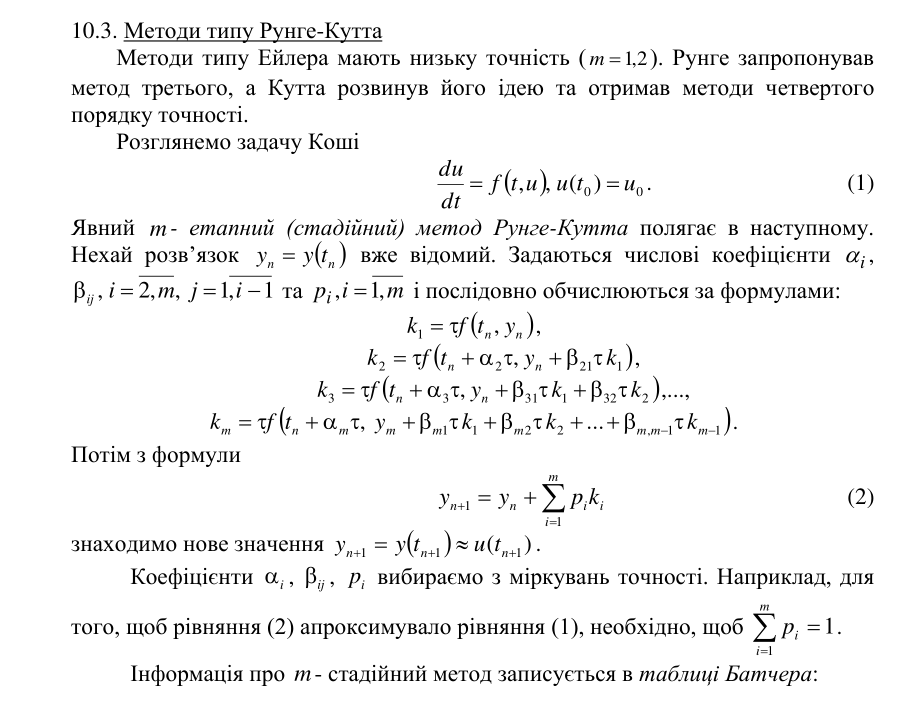  
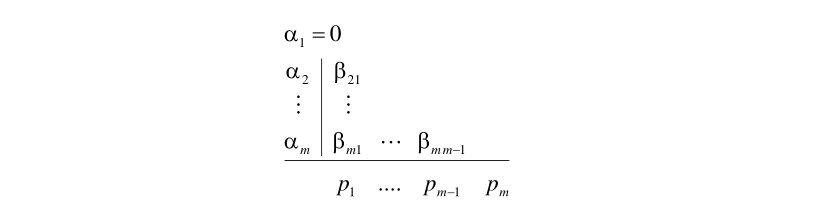

Розглянемо метод із наступною таблицею Батчера:  
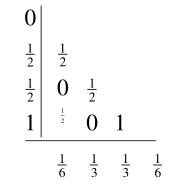  

Тобто  
$k_1 = \tau f(t_n, y_n)$  
$k_2 = \tau f(t_n + \frac{1}{2}\tau, y_n + \frac{1}{2}\tau k_1)$  
$k_3 = \tau f(t_n + \frac{1}{2}\tau, y_n + \frac{1}{2} \tau k_2)$  
$k_4 = \tau f(t_n + \tau, y_n + \frac{1}{2}\tau k_1 +  \tau k_3)$  
$y_{n+1} = y_n + \frac{1}{6}k_1 + \frac{1}{3}k_2 + \frac{1}{3}k_3 + \frac{1}{6}k_4$

<!--
$k_1 = \tau f(t_n, y_n)$  
$k_2 = \tau f(t_n + \alpha_2\tau, y_n + \beta_{21}\tau k_1)$  
$k_3 = \tau f(t_n + \alpha_3\tau, y_n + \beta_{31}\tau k_1 + \beta_{32} \tau k_2)$  
$k_2 = \tau f(t_n + \alpha_4\tau, y_n + \beta_{41}\tau k_1 + \beta_{42}\tau k_2 + \beta_{43}) \tau k_3$   -->

**Похибка методу:** $O(\tau^5)$, тобто це метод 4-го порядку 

# Релізація

In [81]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sympy as sym

def f(t, u):
    return 0.145 * (t**2 + np.cos(0.5*t)) + 0.842*u

def sym_f(t, u):
    return 0.145 * (t**2 + sym.cos(0.5*t)) + 0.842*u

tau = 0.1
tlims = 0.2, 1.2
t0 = 0.2
u0 = 0.25


In [82]:
from dataclasses import dataclass
from time import perf_counter

@dataclass
class Solution:
    tn: np.ndarray
    yn: np.ndarray
    elapsed: float


# stepper: f, n, tau, t_hist, y_hist -> y[n+1]:float
def solver(name):
    def decorator(stepper_func):
        def solve(f, tau, t0, t1, u0):
            print(f"Starting {name} solver.")
            print(f"> tau={tau:.5g},  t=[{t0:.3g}; {t1:.3g}],  u(t0)={u0:.5g}")
            perf0 = perf_counter()

            tn = np.arange(t0, t1+ tau/2, tau, dtype=np.float32)
            N = tn.shape[0]
            yn = np.zeros(N, dtype=np.float32)
            yn[0] = u0
            for n in range(N-1):
                print(f"Step {n+1}, t={tn[n]:.5g}, y={yn[n]:.5g}")
                next_y = stepper_func(f, n, tau, tn, yn)
                yn[n+1] = next_y
            
            perf_elapsed = perf_counter() - perf0
            return Solution(tn, yn, perf_elapsed)
        return solve
    return decorator

## 1. Метод Ойлера

In [83]:
@solver(name="Euler")
def euler_solver(f, n, tau, tn, yn):
    return yn[n] + tau * f(tn[n], yn[n])

ans_euler = euler_solver(f, tau, tlims[0], tlims[1], u0)
print(f"Euler solver took {ans_euler.elapsed:.5g}s")

print()
print("t:", ans_euler.tn.round(4))
print("y:", ans_euler.yn.round(4))



Starting Euler solver.
> tau=0.1,  t=[0.2; 1.2],  u(t0)=0.25
Step 1, t=0.2, y=0.25
Step 2, t=0.3, y=0.28606
Step 3, t=0.4, y=0.32579
Step 4, t=0.5, y=0.36975
Step 5, t=0.6, y=0.41855
Step 6, t=0.7, y=0.47287
Step 7, t=0.8, y=0.53341
Step 8, t=0.9, y=0.60096
Step 9, t=1, y=0.67636
Step 10, t=1.1, y=0.76054
Euler solver took 0.0002504s

t: [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]
y: [0.25   0.2861 0.3258 0.3697 0.4186 0.4729 0.5334 0.601  0.6764 0.7605
 0.8545]


## 2. Модифікований метод Ойлера

In [84]:
@solver(name="ModEuler")
def modeuler_solver(f, n, tau, tn, yn):
    k1 = tau * f(tn[n], yn[n])
    k2 = tau * f(tn[n] + tau/2, yn[n] + k1/2)
    return yn[n] + k2

ans_modeuler = modeuler_solver(f, tau, tlims[0], tlims[1], u0)
print(f"Modified Euler solver took {ans_modeuler.elapsed:.5g}s")

print()
print("t:", ans_modeuler.tn.round(4))
print("y:", ans_modeuler.yn.round(4))


Starting ModEuler solver.
> tau=0.1,  t=[0.2; 1.2],  u(t0)=0.25
Step 1, t=0.2, y=0.25
Step 2, t=0.3, y=0.28786
Step 3, t=0.4, y=0.32983
Step 4, t=0.5, y=0.37654
Step 5, t=0.6, y=0.42867
Step 6, t=0.7, y=0.48695
Step 7, t=0.8, y=0.5522
Step 8, t=0.9, y=0.62529
Step 9, t=1, y=0.70718
Step 10, t=1.1, y=0.79891
Modified Euler solver took 0.0003442s

t: [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]
y: [0.25   0.2879 0.3298 0.3765 0.4287 0.4869 0.5522 0.6253 0.7072 0.7989
 0.9016]


## 3. Рунге-Кутта 4 порядку

In [85]:
@solver(name="RK")
def rk_solver(f, n, tau, tn, yn):
    t,y = tn[n], yn[n]
    k1 = tau * f(t, y)
    k2 = tau * f(t + tau/2, y + tau * k1 / 2)
    k3 = tau * f(t + tau/2, y + tau * k2 / 2)
    k4 = tau * f(t + tau, y + tau * k1 / 2 + tau * k3)
    return y + k1/6 + k2/3 + k3/3 + k4/6

ans_rk = rk_solver(f, tau, tlims[0], tlims[1], u0)
print(f"Runge-Kutta solver took {ans_rk.elapsed:.5g}s")

print()
print("t:", ans_rk.tn.round(4))
print("y:", ans_rk.yn.round(4))


Starting RK solver.
> tau=0.1,  t=[0.2; 1.2],  u(t0)=0.25
Step 1, t=0.2, y=0.25
Step 2, t=0.3, y=0.28653
Step 3, t=0.4, y=0.32692
Step 4, t=0.5, y=0.37175
Step 5, t=0.6, y=0.42164
Step 6, t=0.7, y=0.47729
Step 7, t=0.8, y=0.53944
Step 8, t=0.9, y=0.6089
Step 9, t=1, y=0.68654
Step 10, t=1.1, y=0.77331
Runge-Kutta solver took 0.0002622s

t: [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]
y: [0.25   0.2865 0.3269 0.3717 0.4216 0.4773 0.5394 0.6089 0.6865 0.7733
 0.8703]


## Еталонний розв'язок
Знайду його процедурою чисельного розв'язку ODE в пакеті scipy



In [86]:
tt = np.arange( tlims[0], tlims[1]+ tau/2, tau, dtype=np.float32)
tt

array([0.2       , 0.3       , 0.40000004, 0.5       , 0.6       ,
       0.70000005, 0.8       , 0.90000004, 1.0000001 , 1.1000001 ,
       1.2000002 ], dtype=float32)

In [87]:
import scipy as sp
from time import perf_counter

perf0 = perf_counter()
ans_sp_rk45 = sp.integrate.solve_ivp(f, (tlims[0], tlims[1]+tau/2), [u0], max_step=tau, t_eval=tt)
print(f"SciPy RK45 solver took {perf_counter()-perf0:.5g}s")

print()
print("t:", ans_sp_rk45.t.round(4))
print("y:", ans_sp_rk45.y.round(4))
print()
print(ans_sp_rk45)
ans_sp_rk45 = Solution(ans_sp_rk45.t, ans_sp_rk45.y[0], 0)


SciPy RK45 solver took 0.0057886s

t: [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]
y: [[0.25   0.2879 0.33   0.3768 0.429  0.4874 0.5528 0.6261 0.7082 0.8002
  0.9031]]

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 2.000e-01  3.000e-01  4.000e-01  5.000e-01  6.000e-01
             7.000e-01  8.000e-01  9.000e-01  1.000e+00  1.100e+00
             1.200e+00]
        y: [[ 2.500e-01  2.879e-01  3.300e-01  3.768e-01  4.290e-01
              4.874e-01  5.528e-01  6.261e-01  7.082e-01  8.002e-01
              9.031e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 68
     njev: 0
      nlu: 0


In [88]:
perf0 = perf_counter()
ans_sp_dop853 = sp.integrate.solve_ivp(f, (tlims[0], tlims[1]+tau/2), [u0], max_step=tau, method='DOP853', t_eval=tt)
print(f"SciPy DOP853 solver took {perf_counter()-perf0:.5g}s")

print()
print("t:", ans_sp_dop853.t.round(4))
print("y:", ans_sp_dop853.y.round(4))
print()
print(ans_sp_dop853)
ans_sp_dop853 = Solution(ans_sp_dop853.t, ans_sp_dop853.y[0], 0)


SciPy DOP853 solver took 0.004331s

t: [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]
y: [[0.25   0.2879 0.33   0.3768 0.429  0.4874 0.5528 0.6261 0.7082 0.8002
  0.9031]]

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 2.000e-01  3.000e-01  4.000e-01  5.000e-01  6.000e-01
             7.000e-01  8.000e-01  9.000e-01  1.000e+00  1.100e+00
             1.200e+00]
        y: [[ 2.500e-01  2.879e-01  3.300e-01  3.768e-01  4.290e-01
              4.874e-01  5.528e-01  6.261e-01  7.082e-01  8.002e-01
              9.031e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 164
     njev: 0
      nlu: 0


In [89]:
perf0 = perf_counter()
ans_sp_radau = sp.integrate.solve_ivp(f, (tlims[0], tlims[1]+tau/2), [u0], max_step=tau, method='Radau', t_eval=tt)
print(f"SciPy Radau solver took {perf_counter()-perf0:.5g}s")

print()
print("t:", ans_sp_radau.t.round(4))
print("y:", ans_sp_radau.y.round(4))
print()
print(ans_sp_radau)
ans_sp_radau = Solution(ans_sp_radau.t, ans_sp_radau.y[0], 0)

SciPy Radau solver took 0.006312s

t: [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]
y: [[0.25   0.2879 0.33   0.3768 0.429  0.4874 0.5528 0.6261 0.7082 0.8002
  0.9031]]

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 2.000e-01  3.000e-01  4.000e-01  5.000e-01  6.000e-01
             7.000e-01  8.000e-01  9.000e-01  1.000e+00  1.100e+00
             1.200e+00]
        y: [[ 2.500e-01  2.879e-01  3.300e-01  3.768e-01  4.290e-01
              4.874e-01  5.528e-01  6.261e-01  7.082e-01  8.002e-01
              9.031e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 79
     njev: 1
      nlu: 22


## Порівняння 

Text(0.5, 1.0, 'Numerical solutions')

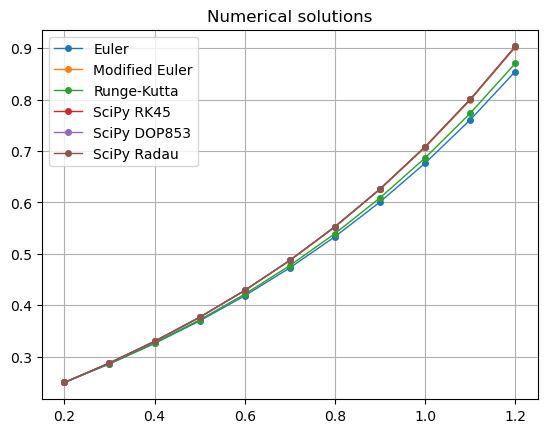

In [101]:
answers = [ans_euler, ans_modeuler, ans_rk, ans_sp_rk45, ans_sp_dop853, ans_sp_radau]
labels = ['Euler', 'Modified Euler', 'Runge-Kutta', 'SciPy RK45', 'SciPy DOP853', 'SciPy Radau']
for ans, label in zip(answers, labels):
    plt.plot(ans.tn, ans.yn, 'o-', label=label, lw=1, markersize=4)
plt.legend()
plt.grid()
plt.title("Numerical solutions")

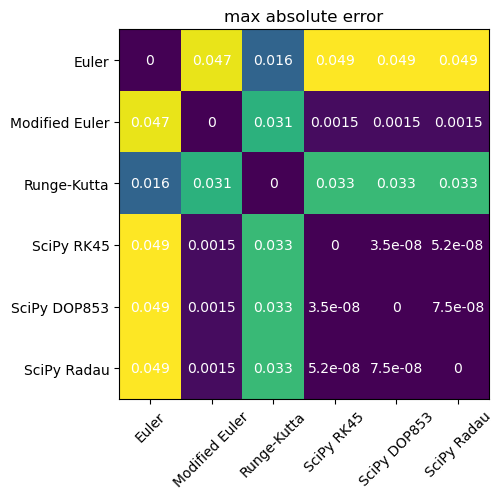

In [113]:
distances = np.zeros((6,6), dtype=np.float32)
for i in range(6):
    for j in range(i,6):
        d = np.abs(answers[i].yn - answers[j].yn).max()
        distances[i,j] = d
        distances[j,i] = d

plt.imshow(distances, cmap='viridis')
plt.title('max absolute error')
plt.xticks(np.arange(6), labels, rotation=45)
plt.yticks(np.arange(6), labels)
for i in range(6):
    for j in range(6):
        plt.text(i,j, f"{distances[i,j]:.2g}", ha='center', va='center', color='w')

Три різні методи SciPi узгоджуються між собою.

Якщо довіряти методам, реалізованим в SciPy, то найкраще себе показав мій модифікований метод Ойлера